In [35]:
## loading in all the important functions that we had in the prev phase-> i put all of them in a utils file
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sfm_utils import (
    load_gray_image,
    match_features,
    build_intrinsics_from_image_size
)

DATASET_DIR = r"C:\Users\pc\OneDrive\Desktop\CV_Project\dataset2"


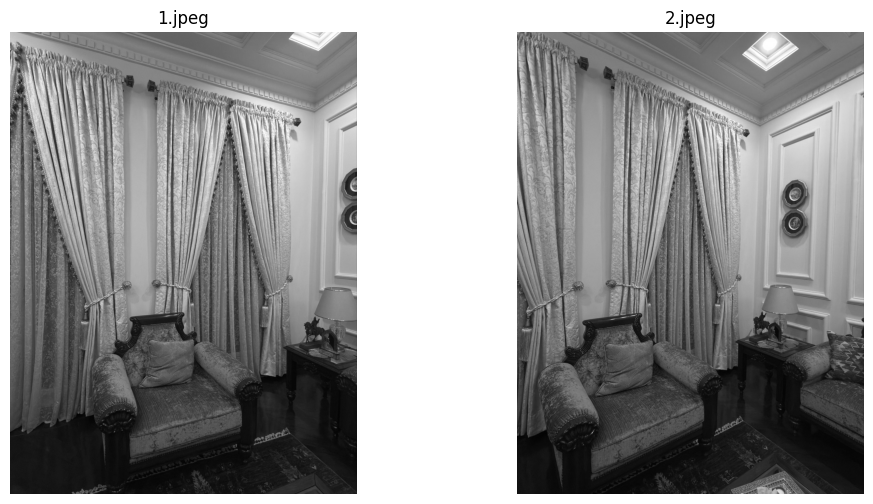

iphone matrix K =
 [[633.33333333   0.         600.        ]
 [  0.         633.33333333 800.        ]
 [  0.           0.           1.        ]]


In [36]:
## IMAGES USED
img1_name = "1.jpeg"
img2_name = "2.jpeg"

img1 = load_gray_image(DATASET_DIR, img1_name)
img2 = load_gray_image(DATASET_DIR, img2_name)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.title(img1_name)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.title(img2_name)
plt.axis('off')

plt.show()


## keeping this code in here because im unsure which K i would be using in phase 3. but for now the point cloud seems better using the iphones matrix
# h, w = img1.shape[:2]
# K = build_intrinsics_from_image_size(w, h)


h, w = img1.shape[:2]
f35 = 19.0   ## taken from the exif file
sensor_width_35mm = 36.0

fx = fy = (f35 / sensor_width_35mm) * w
cx = w / 2.0
cy = h / 2.0

K_iphone = np.array([
    [fx, 0.0, cx],
    [0.0, fy, cy],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

print("iphone matrix K =\n", K_iphone)

K = K_iphone

Number of good matches = 2881


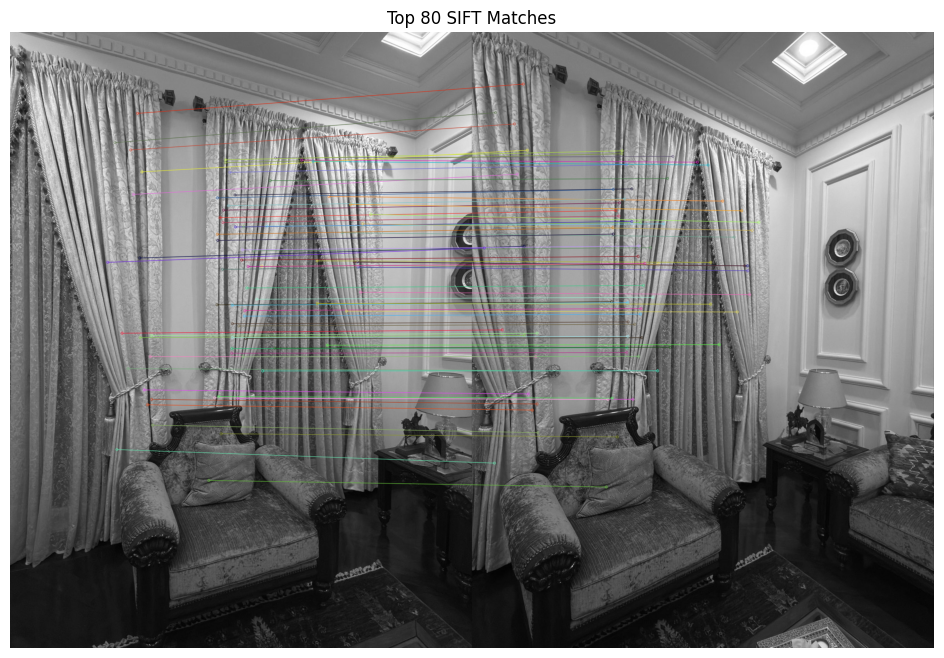

In [37]:
## now we need to match features between these two images 
kp1, kp2, good_matches = match_features(img1, img2) ## this function was in the last ipynb -> now in utils
print("Number of good matches =", len(good_matches))

good_sorted = sorted(good_matches, key=lambda m: m.distance)[:80]
vis = cv2.drawMatches(img1, kp1, img2, kp2, good_sorted, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(18,8))
plt.imshow(vis, cmap='gray')
plt.title("Top 80 SIFT Matches")
plt.axis('off')
plt.show()



In [38]:
## extractiubng good matches
pts1 = []
pts2 = []

for m in good_matches:
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1, dtype=np.float64)
pts2 = np.array(pts2, dtype=np.float64)

print("Points:", pts1.shape, pts2.shape)


Points: (2881, 2) (2881, 2)


In [39]:
## COMPUTING ESENTIAL MATRIX
E, mask = cv2.findEssentialMat(
    pts1, pts2,
    K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0
)

print("Essential Matrix E =\n", E)
print("Inliers =", np.sum(mask), "/", len(mask))


Essential Matrix E =
 [[ 5.78505914e-03 -1.14982401e-01  3.56462905e-02]
 [-1.84108196e-02 -1.36045963e-04 -7.05937134e-01]
 [-2.92628013e-02  6.97057925e-01  6.53042698e-03]]
Inliers = 2642 / 2881


In [40]:
## filter inliners 
pts1_in = pts1[mask.ravel() == 1]
pts2_in = pts2[mask.ravel() == 1]


In [41]:
## recovering Pose
_, R, t, mask_pose = cv2.recoverPose(E, pts1_in, pts2_in, K)

print("Recovered Rotation R =\n", R)
print("Recovered translation t =\n", t)


Recovered Rotation R =
 [[ 9.82045407e-01 -9.00680219e-03 -1.88429551e-01]
 [ 9.08863636e-03  9.99958605e-01 -4.29740214e-04]
 [ 1.88425621e-01 -1.29054326e-03  9.82086615e-01]]
Recovered translation t =
 [[-0.98536787]
 [-0.05125985]
 [-0.16255025]]


In [42]:
## Triangulate

## build the camera proj matrices
## C1 = [I|0]
## C2 = [R|t]

P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])
P2 = K @ np.hstack([R, t])

## the points to triangulate
pts1_T = pts1_in.T
pts2_T = pts2_in.T

points_4d = cv2.triangulatePoints(P1, P2, pts1_T, pts2_T)
points_3d = (points_4d[:3] / points_4d[3]).T

print("Triangulated 3D points:", points_3d.shape)


Triangulated 3D points: (2642, 3)


In [43]:
## saving point cloud
def save_ply(points, filename="point_cloud.ply"):
    with open(filename, "w") as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("end_header\n")
        for x,y,z in points:
            f.write(f"{x} {y} {z}\n")

save_ply(points_3d, "two_view_cloud.ply")
print("Saved point cloud as two_view_cloud.ply")


Saved point cloud as two_view_cloud.ply


In [44]:
## SANITY CHECKS TO SEE KE SAHI BHI HAI

X = points_3d.T
X_cam1 = X
z1 = X_cam1[2, :]

X_cam2 = R @ X + t
z2 = X_cam2[2, :]

in_front = (z1 > 0) & (z2 > 0)
print("Points in front of both cameras:", np.sum(in_front), "/", X.shape[1])

points_3d_valid = points_3d[in_front]
print("Valid 3D points:", points_3d_valid.shape)

def project_points(P, points_3d):
    N = points_3d.shape[0]
    homog = np.hstack([points_3d, np.ones((N, 1))]) 
    proj = (P @ homog.T).T
    proj = proj[:, :2] / proj[:, 2:3]
    return proj

P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])
P2 = K @ np.hstack([R, t])

pts3d = points_3d_valid if 'points_3d_valid' in globals() else points_3d
pts1 = pts1_in[in_front] if 'points_3d_valid' in globals() else pts1_in
pts2 = pts2_in[in_front] if 'points_3d_valid' in globals() else pts2_in

proj1 = project_points(P1, pts3d)
proj2 = project_points(P2, pts3d)

err1 = np.linalg.norm(proj1 - pts1, axis=1)
err2 = np.linalg.norm(proj2 - pts2, axis=1)

print("Reprojection error (image 1): mean =", np.mean(err1), "px, median =", np.median(err1))
print("Reprojection error (image 2): mean =", np.mean(err2), "px, median =", np.median(err2))

## OK SEEMS GOOD ENIUGH. THE MEAN ERROR IS ALMOST SIMILAR TO RHAT OF THE GENERIC K MATRRIX AND SEEMS GOOD ENOIGH

Points in front of both cameras: 2642 / 2642
Valid 3D points: (2642, 3)
Reprojection error (image 1): mean = 0.17763289371439878 px, median = 0.13158051417769756
Reprojection error (image 2): mean = 0.18286017967209164 px, median = 0.13669413854292967


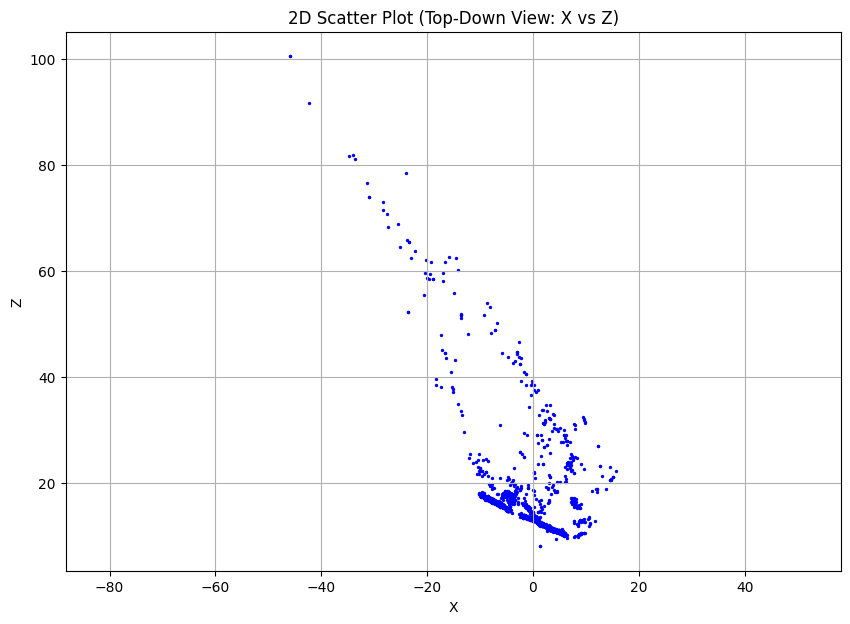

In [45]:
## 2D VISUALISATION 
pts3d = points_3d_valid if 'points_3d_valid' in globals() else points_3d

plt.figure(figsize=(10, 7))
plt.scatter(pts3d[:, 0], pts3d[:, 2], s=2, c='blue')
plt.xlabel("X")
plt.ylabel("Z")
plt.title("2D Scatter Plot (Top-Down View: X vs Z)")
plt.grid(True)
plt.axis('equal')
plt.show()


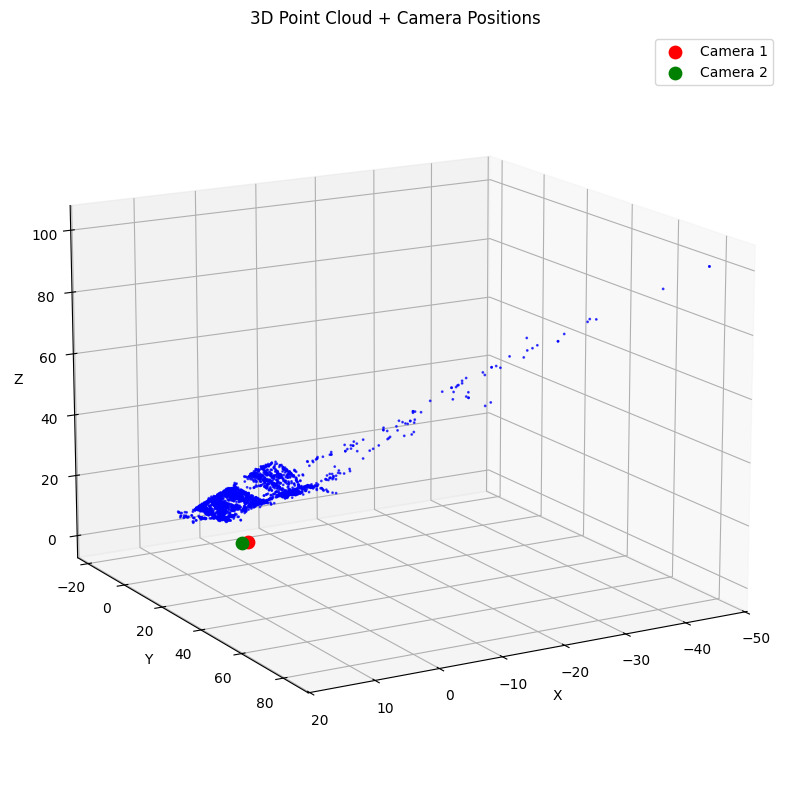

In [46]:
## 3D POINT CLOUD VIS

from mpl_toolkits.mplot3d import Axes3D

pts3d = points_3d_valid if 'points_3d_valid' in globals() else points_3d

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts3d[:, 0], pts3d[:, 1], pts3d[:, 2], s=1, c='blue', alpha=0.7)

C1 = np.array([0, 0, 0])
C2 = -R.T @ t

ax.scatter(C1[0], C1[1], C1[2], c='red', s=80, label='Camera 1')

ax.scatter(C2[0], C2[1], C2[2], c='green', s=80, label='Camera 2')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("3D Point Cloud + Camera Positions")
ax.legend()

ax.view_init(elev=15, azim=60)

plt.show()


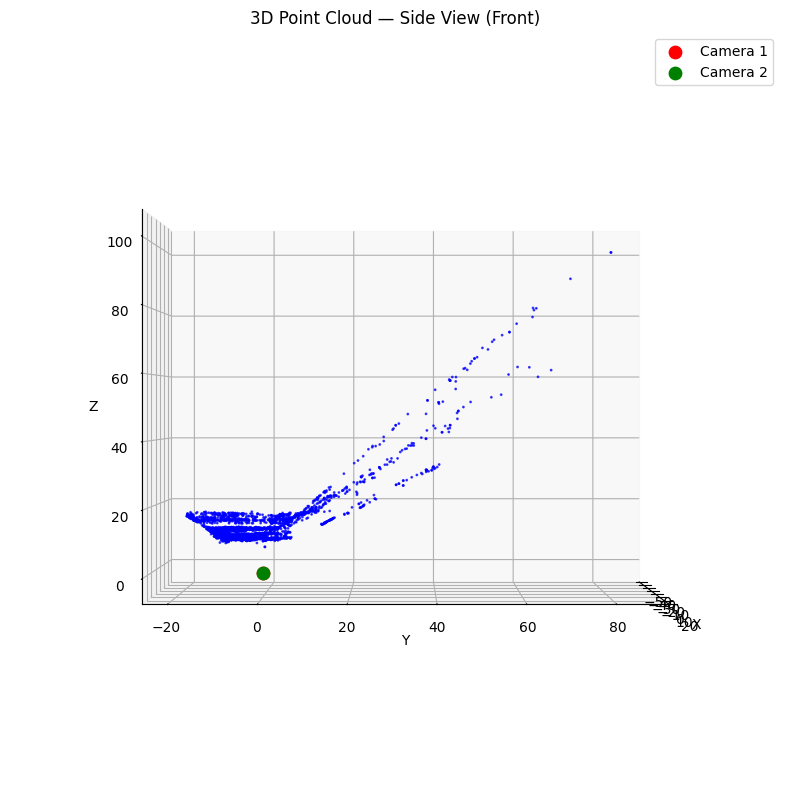

In [47]:
## SIDE VIEW 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts3d[:, 0], pts3d[:, 1], pts3d[:, 2], s=1, c='blue', alpha=0.7)

ax.scatter(C1[0], C1[1], C1[2], c='red', s=80, label='Camera 1')
ax.scatter(C2[0], C2[1], C2[2], c='green', s=80, label='Camera 2')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

ax.view_init(elev=0, azim=0) 

plt.title("3D Point Cloud — Side View (Front)")
plt.show()


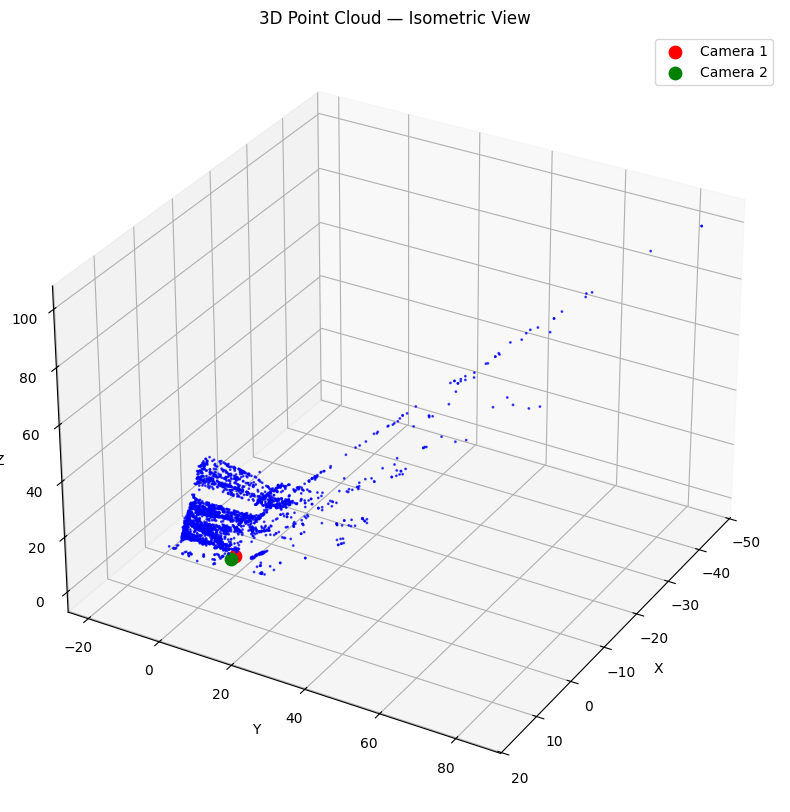

In [48]:
## ISOMETIC VIEW 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts3d[:, 0], pts3d[:, 1], pts3d[:, 2], s=1, c='blue', alpha=0.7)

ax.scatter(C1[0], C1[1], C1[2], c='red', s=80, label='Camera 1')
ax.scatter(C2[0], C2[1], C2[2], c='green', s=80, label='Camera 2')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

ax.view_init(elev=30, azim=30)

plt.title("3D Point Cloud — Isometric View")
plt.show()
